In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import numpy as np

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


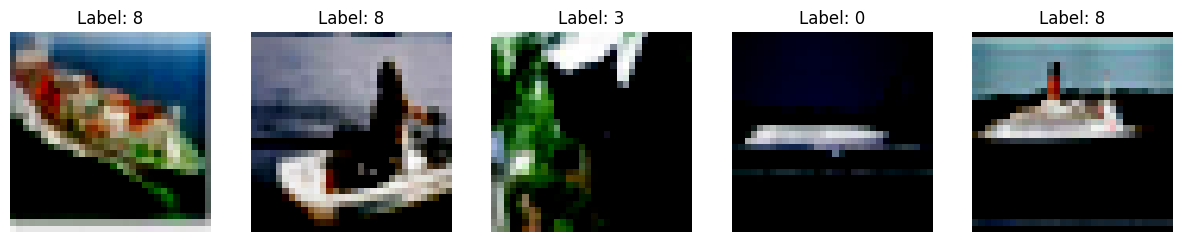

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


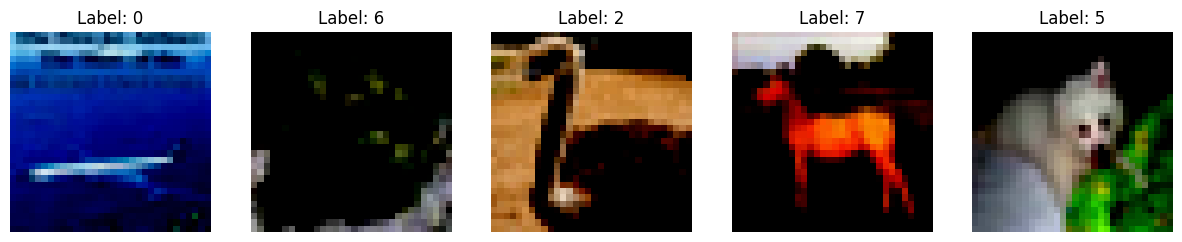

In [4]:
import random

# Function to display random images with labels from the dataset
def display_random_images_with_labels(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Display random images with labels from the training dataset
display_random_images_with_labels(train_dataset)

# Display random images with labels from the test dataset
display_random_images_with_labels(test_dataset)

In [5]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
# Display sizes of train, test, and validation sets
print(f"Size of the training set: {len(train_dataset)}")
print(f"Size of the validation set: {len(val_dataset)}")
print(f"Size of the test set: {len(test_dataset)}")

Size of the training set: 40000
Size of the validation set: 10000
Size of the test set: 10000


In [7]:
# Move data loaders to GPU if available
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()  # Record start time for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted_probs = torch.softmax(outputs, 1)
            _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted_probs = torch.softmax(outputs, 1)
                _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        end_time = time.time()  # Record end time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch time

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f} seconds")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs

In [9]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            outputs = model(inputs)
            predicted = torch.argmax(torch.softmax(outputs, 1), dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy

### Variant 2:

In [10]:
# Define Mini-VGG network
class MiniVGG_v2(nn.Module):
    def __init__(self):
        super(MiniVGG_v2, self).__init__()  # Corrected the superclass call to MiniVGG_v2
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)  # Stride=2 for size reduction
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, stride=2)  # Stride=2 for size reduction
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted input size due to stride=2 conv layers
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(-1, 256 * 8 * 8)  # Adjusted flatten size due to stride=2 conv layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Define table headers and data
headers = ["Layer Type", "Window Size", "Number of Filters"]
data = [
    ["Convolutional", "(3x3)", "64"],
    ["Convolutional", "(3x3)", "64"],
    ["Convolutional (Stride=2)", "(3x3)", "128"],
    ["Convolutional", "(3x3)", "128"],
    ["Convolutional (Stride=2)", "(3x3)", "256"],
    ["Convolutional", "(3x3)", "256"],
    ["Fully Connected", "-", "512"],
    ["Fully Connected", "-", "10"]
]

# Display table
print(tabulate(data, headers=headers, tablefmt="grid"))

+--------------------------+---------------+---------------------+
| Layer Type               | Window Size   |   Number of Filters |
+==========================+===============+=====================+
| Convolutional            | (3x3)         |                  64 |
+--------------------------+---------------+---------------------+
| Convolutional            | (3x3)         |                  64 |
+--------------------------+---------------+---------------------+
| Convolutional (Stride=2) | (3x3)         |                 128 |
+--------------------------+---------------+---------------------+
| Convolutional            | (3x3)         |                 128 |
+--------------------------+---------------+---------------------+
| Convolutional (Stride=2) | (3x3)         |                 256 |
+--------------------------+---------------+---------------------+
| Convolutional            | (3x3)         |                 256 |
+--------------------------+---------------+------------------

In [12]:
model_v2 = MiniVGG_v2().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

# Train MiniVGG model
train_losses, val_losses, train_accs, val_accs = train(model_v2, criterion, optimizer, train_loader, val_loader)

Epoch 1/100, Train Loss: 1.6169, Val Loss: 1.3000, Train Acc: 0.4052, Val Acc: 0.5323, Time: 3.84 seconds
Epoch 2/100, Train Loss: 1.1041, Val Loss: 0.9986, Train Acc: 0.6079, Val Acc: 0.6476, Time: 6.33 seconds
Epoch 3/100, Train Loss: 0.8133, Val Loss: 0.8431, Train Acc: 0.7124, Val Acc: 0.7097, Time: 8.34 seconds
Epoch 4/100, Train Loss: 0.5901, Val Loss: 0.8581, Train Acc: 0.7915, Val Acc: 0.7104, Time: 8.38 seconds
Epoch 5/100, Train Loss: 0.3737, Val Loss: 0.9941, Train Acc: 0.8678, Val Acc: 0.7147, Time: 8.40 seconds
Epoch 6/100, Train Loss: 0.2098, Val Loss: 1.1484, Train Acc: 0.9270, Val Acc: 0.7028, Time: 8.24 seconds
Epoch 7/100, Train Loss: 0.1299, Val Loss: 1.4573, Train Acc: 0.9552, Val Acc: 0.7141, Time: 8.19 seconds
Epoch 8/100, Train Loss: 0.1030, Val Loss: 1.6911, Train Acc: 0.9646, Val Acc: 0.7008, Time: 8.23 seconds
Epoch 9/100, Train Loss: 0.0875, Val Loss: 1.7243, Train Acc: 0.9703, Val Acc: 0.7084, Time: 8.16 seconds
Epoch 10/100, Train Loss: 0.0837, Val Loss: 1.

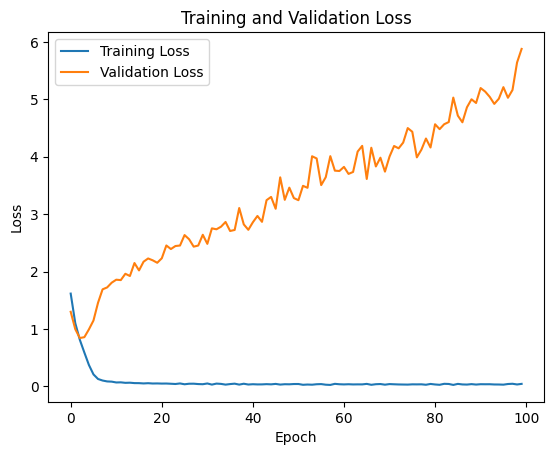

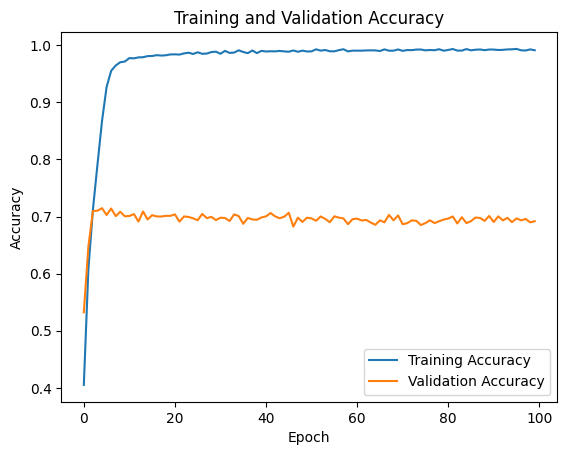

Test Accuracy for MiniVGG_v2 model: 0.6866


In [13]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Test the model
test_accuracy = test(model_v2, test_loader)
print(f"Test Accuracy for MiniVGG_v2 model: {test_accuracy:.4f}")

###  Batch Normalization

In [14]:
class MiniVGG_v2_BN(nn.Module):
    def __init__(self):
        super(MiniVGG_v2_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = torch.relu(self.bn5(self.conv5(x)))
        x = torch.relu(self.bn6(self.conv6(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Data Augmentation

In [15]:
# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

# Define data loaders
# Move train and validation data loaders to GPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Display the number of samples in the training, validation, and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of validation samples: 10000
Number of testing samples: 10000


In [16]:
# Initialize MiniVGG_v2_BN model
model_v2 = MiniVGG_v2_BN().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

# Train MiniVGG_v2_BN model
train_losses, val_losses, train_accs, val_accs = train(model_v2, criterion, optimizer, train_loader, val_loader)

Epoch 1/100, Train Loss: 1.6143, Val Loss: 1.3305, Train Acc: 0.4141, Val Acc: 0.5134, Time: 11.04 seconds
Epoch 2/100, Train Loss: 1.2018, Val Loss: 1.0542, Train Acc: 0.5684, Val Acc: 0.6227, Time: 11.23 seconds
Epoch 3/100, Train Loss: 0.9993, Val Loss: 0.8763, Train Acc: 0.6460, Val Acc: 0.6866, Time: 10.31 seconds
Epoch 4/100, Train Loss: 0.8660, Val Loss: 0.8121, Train Acc: 0.6938, Val Acc: 0.7228, Time: 11.00 seconds
Epoch 5/100, Train Loss: 0.7723, Val Loss: 0.7260, Train Acc: 0.7286, Val Acc: 0.7469, Time: 10.78 seconds
Epoch 6/100, Train Loss: 0.7027, Val Loss: 0.6201, Train Acc: 0.7539, Val Acc: 0.7868, Time: 10.77 seconds
Epoch 7/100, Train Loss: 0.6475, Val Loss: 0.5698, Train Acc: 0.7738, Val Acc: 0.8002, Time: 11.16 seconds
Epoch 8/100, Train Loss: 0.5978, Val Loss: 0.5290, Train Acc: 0.7926, Val Acc: 0.8185, Time: 11.27 seconds
Epoch 9/100, Train Loss: 0.5611, Val Loss: 0.5501, Train Acc: 0.8050, Val Acc: 0.8133, Time: 11.15 seconds
Epoch 10/100, Train Loss: 0.5181, Val

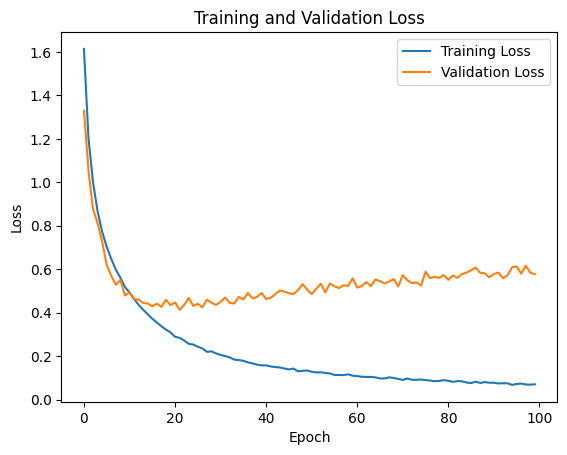

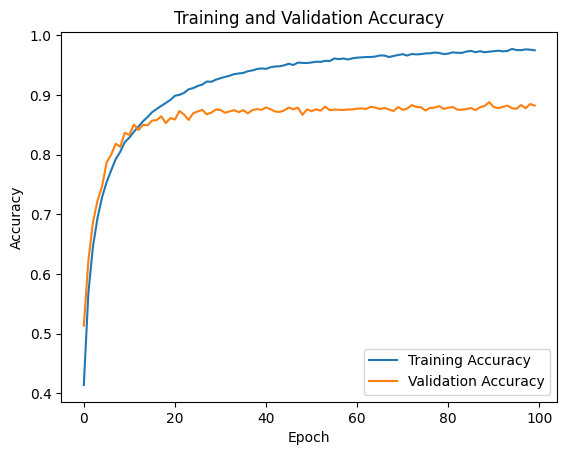

Test Accuracy for MiniVGG_v2 model (with Batch Normalization): 0.8824


In [17]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Test the model
test_accuracy = test(model_v2, test_loader)
print(f"Test Accuracy for MiniVGG_v2 model (with Batch Normalization): {test_accuracy:.4f}")

### L2 Regularization with weight decay of 0.0001

In [18]:
# Move MiniVGG_BN model to GPU
model_bn = MiniVGG_v2_BN().to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001, weight_decay=0.0001)  # Adding L2 regularization with weight decay

# Train MiniVGG_BN model with early stopping
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_bn, criterion, optimizer_bn, train_loader, val_loader)

Epoch 1/100, Train Loss: 1.6301, Val Loss: 1.2856, Train Acc: 0.4086, Val Acc: 0.5394, Time: 10.99 seconds
Epoch 2/100, Train Loss: 1.1754, Val Loss: 1.0262, Train Acc: 0.5767, Val Acc: 0.6350, Time: 10.99 seconds
Epoch 3/100, Train Loss: 0.9738, Val Loss: 0.7965, Train Acc: 0.6554, Val Acc: 0.7212, Time: 10.73 seconds
Epoch 4/100, Train Loss: 0.8514, Val Loss: 0.7887, Train Acc: 0.7008, Val Acc: 0.7265, Time: 10.66 seconds
Epoch 5/100, Train Loss: 0.7632, Val Loss: 0.7224, Train Acc: 0.7323, Val Acc: 0.7533, Time: 11.09 seconds
Epoch 6/100, Train Loss: 0.7062, Val Loss: 0.6352, Train Acc: 0.7550, Val Acc: 0.7892, Time: 10.90 seconds
Epoch 7/100, Train Loss: 0.6533, Val Loss: 0.5637, Train Acc: 0.7722, Val Acc: 0.8072, Time: 11.02 seconds
Epoch 8/100, Train Loss: 0.6137, Val Loss: 0.6137, Train Acc: 0.7866, Val Acc: 0.7982, Time: 11.15 seconds
Epoch 9/100, Train Loss: 0.5746, Val Loss: 0.5357, Train Acc: 0.8015, Val Acc: 0.8139, Time: 11.62 seconds
Epoch 10/100, Train Loss: 0.5455, Val

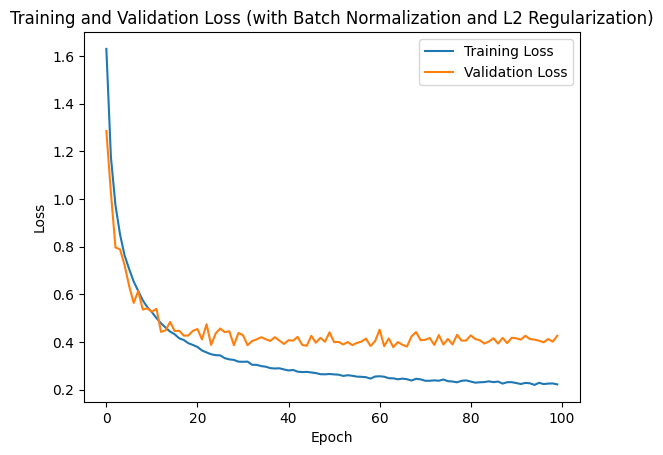

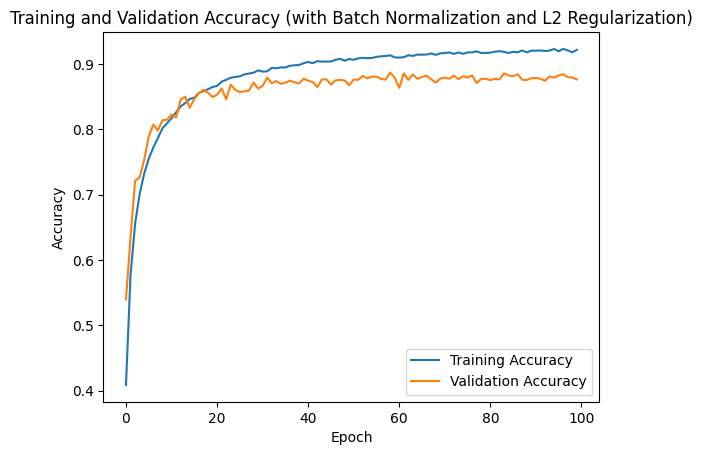

Test Accuracy for MiniVGG_v2_BN model (with Batch Normalization and L2 Regularization): 0.8764


In [19]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

test_accuracy_bn = test(model_bn, test_loader)
print(f"Test Accuracy for MiniVGG_v2_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Adding Dropout with probability of 0.1

In [38]:
class MiniVGG_v2_BN_dropout(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(MiniVGG_v2_BN_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = torch.relu(self.bn5(self.conv5(x)))
        x = torch.relu(self.bn6(self.conv6(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout to the output of fc1
        x = self.fc2(x)
        return x

In [39]:
# Move MiniVGG_BN_dropout model to GPU with dropout probability of 0.1
dropout_prob = 0.1
model_bn_dropout = MiniVGG_v2_BN_dropout(dropout_prob=dropout_prob).to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer_bn_dropout = optim.Adam(model_bn_dropout.parameters(), lr=0.001, weight_decay=0.0001)  # Adding L2 regularization with weight decay

# Train MiniVGG_BN_dropout model with early stopping
train_losses_bn_dropout, val_losses_bn_dropout, train_accs_bn_dropout, val_accs_bn_dropout = train(model_bn_dropout, criterion, optimizer_bn_dropout, train_loader, val_loader, num_epochs = 150)

Epoch 1/150, Train Loss: 1.6416, Val Loss: 1.1812, Train Acc: 0.4076, Val Acc: 0.5655, Time: 10.03 seconds
Epoch 2/150, Train Loss: 1.2332, Val Loss: 1.0091, Train Acc: 0.5577, Val Acc: 0.6460, Time: 9.98 seconds
Epoch 3/150, Train Loss: 1.0657, Val Loss: 0.8861, Train Acc: 0.6238, Val Acc: 0.6813, Time: 9.70 seconds
Epoch 4/150, Train Loss: 0.9406, Val Loss: 0.8210, Train Acc: 0.6699, Val Acc: 0.7166, Time: 9.56 seconds
Epoch 5/150, Train Loss: 0.8516, Val Loss: 0.7108, Train Acc: 0.7044, Val Acc: 0.7569, Time: 9.78 seconds
Epoch 6/150, Train Loss: 0.7823, Val Loss: 0.6528, Train Acc: 0.7290, Val Acc: 0.7789, Time: 9.59 seconds
Epoch 7/150, Train Loss: 0.7258, Val Loss: 0.6160, Train Acc: 0.7514, Val Acc: 0.7887, Time: 9.85 seconds
Epoch 8/150, Train Loss: 0.6869, Val Loss: 0.5825, Train Acc: 0.7632, Val Acc: 0.8002, Time: 9.83 seconds
Epoch 9/150, Train Loss: 0.6510, Val Loss: 0.5827, Train Acc: 0.7746, Val Acc: 0.8063, Time: 9.26 seconds
Epoch 10/150, Train Loss: 0.6171, Val Loss: 0

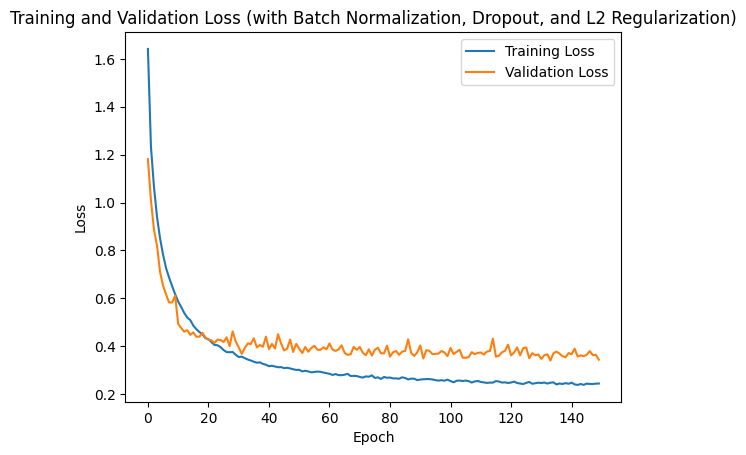

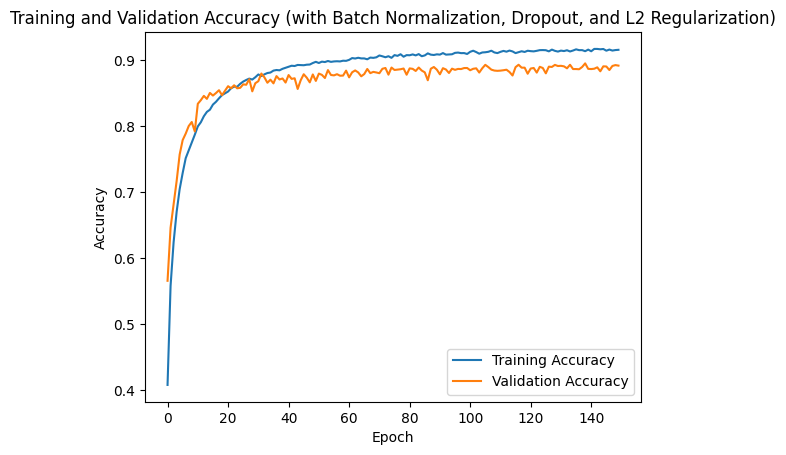

Test Accuracy for MiniVGG_v2_BN_dropout model (with Batch Normalization, Dropout, and L2 Regularization): 0.8918


In [40]:
# Plotting training and validation loss
plt.plot(train_losses_bn_dropout, label='Training Loss')
plt.plot(val_losses_bn_dropout, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization, Dropout, and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn_dropout, label='Training Accuracy')
plt.plot(val_accs_bn_dropout, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization, Dropout, and L2 Regularization)')
plt.legend()
plt.show()

# Calculate and print test accuracy
test_accuracy_bn_dropout = test(model_bn_dropout, test_loader)
print(f"Test Accuracy for MiniVGG_v2_BN_dropout model (with Batch Normalization, Dropout, and L2 Regularization): {test_accuracy_bn_dropout:.4f}")